In [4]:
import pandas as pd
import numpy as np
import pickle
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from datetime import datetime
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [5]:
dateparse = lambda x: datetime.strptime(x, '%Y/%m/%d') if isinstance(x, str) else x

In [6]:
# Load the data
data = pd.read_excel('SignedPlayersDatasetVALORANT.xlsx', parse_dates=['date'], date_parser=dateparse)
# Fix name errors
data = data.replace('\n','', regex=True)
data = data.replace(' ','', regex=True)
#test_data = pd.read_excel('Test Dataset VALORANT VCT DATASET.xlsx', parse_dates=['date'], date_parser=dateparse).dropna(how='any',axis=0)

In [7]:
# Select features and target variable
input_features = ['date', 'player']
features = ['kills_per_round', 'assists_per_round', 'average_damage_per_round',
            'first_kills_per_round', 'first_deaths_per_round', 'headshot_percentage',
            'clutch_success_percentage', 'total_kills', 'total_deaths', 'total_assists',
            'total_first_kills', 'total_first_deaths']
target_variable = 'average_combat_score'
#Note: create models w/ target variable for rounds and rating

In [8]:
# Get dates and players
dates = data['date'].unique()
players = data['player'].unique()

In [9]:
# For getting difference in months
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

def months_from_2021(dates):
    months_from_Jan_2021 = []
    for date in dates:
        months_from_Jan_2021.append(diff_month(date, datetime.strptime('2021/01/01', '%Y/%m/%d')))
    return months_from_Jan_2021

In [42]:
#Load models

ACS_model_file_name = 'model.sav'
feature_model_tree_file_name = 'player_feature_models.sav'
feature_model_linear_file_name = 'player_feature_models_linear.sav'
feature_model_xgb_file_name = 'player_feature_models_XGB.sav'

model = pickle.load(open(ACS_model_file_name, 'rb'))
player_feature_models_tree = pickle.load(open(feature_model_tree_file_name, 'rb'))
player_feature_models_linear = pickle.load(open(feature_model_linear_file_name, 'rb'))
player_feature_models_XGB = pickle.load(open(feature_model_xgb_file_name, 'rb'))

feature_models = player_feature_models_linear

In [15]:
#Predict Functions

In [16]:
def predict_player_feature(player, date, feature):
    date_array = [dateparse(date)]
    date_from_Jan_2021 = months_from_2021(date_array)
    return feature_models.get(player).get(feature).predict(np.array([date_from_Jan_2021]))[0]

In [17]:
def predict_players_values(players_and_dates):
    players_and_dates = players_and_dates.assign(months_from_Jan_2021 = months_from_2021(players_and_dates['date']))
    player_predicted_values = pd.DataFrame()
    for feature in features:
        player_values = []
        for player_and_date in players_and_dates.itertuples():
            player_values.append(predict_player_feature(player_and_date.player, player_and_date.date, feature))
        player_predicted_values[feature] = player_values
    return pd.DataFrame(player_predicted_values)

In [18]:
#Predict ACS
def predictACS(players_and_dates):
    return model.predict(predict_players_values(players_and_dates))

In [19]:
#Player predictions on date
#Note: Use pandas dataframe on this. 
def playerStatPredictions(players_and_dates):
    players_predictions = players_and_dates.copy()
    players_predictions = pd.merge(players_predictions, predict_players_values(players_and_dates), left_index=True, right_index=True)
    players_predictions['average_combat_score'] = predictACS(players_and_dates)
    return players_predictions

In [20]:
#Get all players in dates
def all_players_date(dates_used):
    index = pd.MultiIndex.from_product([players, dates_used], names = ["player", "date"])
    players_dates_pd = pd.DataFrame(index = index).reset_index()
    players_dates_pd['date'] = pd.to_datetime(players_dates_pd['date'])
    return players_dates_pd

In [46]:
#Test models
def test_model():
    model_mse = pd.DataFrame()
    prediction_features = predict_players_values(data[['player', 'date']])
    prediction_ACS = predictACS(data[['player', 'date']])
    model_mse['ACS_mse'] = [mean_squared_error(data['average_combat_score'], prediction_ACS)]
    model_mse['ACS_mape'] = [mean_absolute_percentage_error(data['average_combat_score'], prediction_ACS)]
    for feature in features:
        model_mse[feature + '_mse'] = [mean_squared_error(data[feature], prediction_features[feature])]
        model_mse[feature + '_mape'] = [mean_absolute_percentage_error(data[feature], prediction_features[feature])]
    return model_mse

In [47]:
feature_models = player_feature_models_tree
test_model()

,ACS_mse,ACS_mape,kills_per_round_mse,kills_per_round_mape,assists_per_round_mse,assists_per_round_mape,average_damage_per_round_mse,average_damage_per_round_mape,first_kills_per_round_mse,first_kills_per_round_mape,...,total_kills_mse,total_kills_mape,total_deaths_mse,total_deaths_mape,total_assists_mse,total_assists_mape,total_first_kills_mse,total_first_kills_mape,total_first_deaths_mse,total_first_deaths_mape
0,60.203662,0.026703,0.000474,0.012283,0.000245,0.0225,16.852039,0.012092,0.000058,0.030464,...,201.661483,0.041343,140.705742,0.033312,59.518142,0.055635,5.880183,0.044905,8.216906,0.063349


In [48]:
feature_models = player_feature_models_linear
test_model()

,ACS_mse,ACS_mape,kills_per_round_mse,kills_per_round_mape,assists_per_round_mse,assists_per_round_mape,average_damage_per_round_mse,average_damage_per_round_mape,first_kills_per_round_mse,first_kills_per_round_mape,...,total_kills_mse,total_kills_mape,total_deaths_mse,total_deaths_mape,total_assists_mse,total_assists_mape,total_first_kills_mse,total_first_kills_mape,total_first_deaths_mse,total_first_deaths_mape
0,271.227662,0.064493,0.003194,0.062524,0.002573,1.004233e+12,92.516963,0.05568,0.00112,2.880449e+12,...,3468.118994,0.495511,2894.644255,0.418523,688.335563,1.207519e+14,108.945212,4.469094e+14,92.214232,1.227801e+14


In [49]:
feature_models = player_feature_models_XGB
test_model(player_feature_models_XGB)

,ACS_mse,ACS_mape,kills_per_round_mse,kills_per_round_mape,assists_per_round_mse,assists_per_round_mape,average_damage_per_round_mse,average_damage_per_round_mape,first_kills_per_round_mse,first_kills_per_round_mape,...,total_kills_mse,total_kills_mape,total_deaths_mse,total_deaths_mape,total_assists_mse,total_assists_mape,total_first_kills_mse,total_first_kills_mape,total_first_deaths_mse,total_first_deaths_mape
0,51.783347,0.02423,0.000365,0.009679,0.000181,1.731347e+10,13.572597,0.008504,0.000044,1.095412e+11,...,125.275121,0.029984,94.828949,0.024306,32.9378,1.698273e+10,3.081341,7.700147e+10,3.822968,1.982835e+10


In [50]:
prediction_ACS = predictACS(data[['player', 'date']])

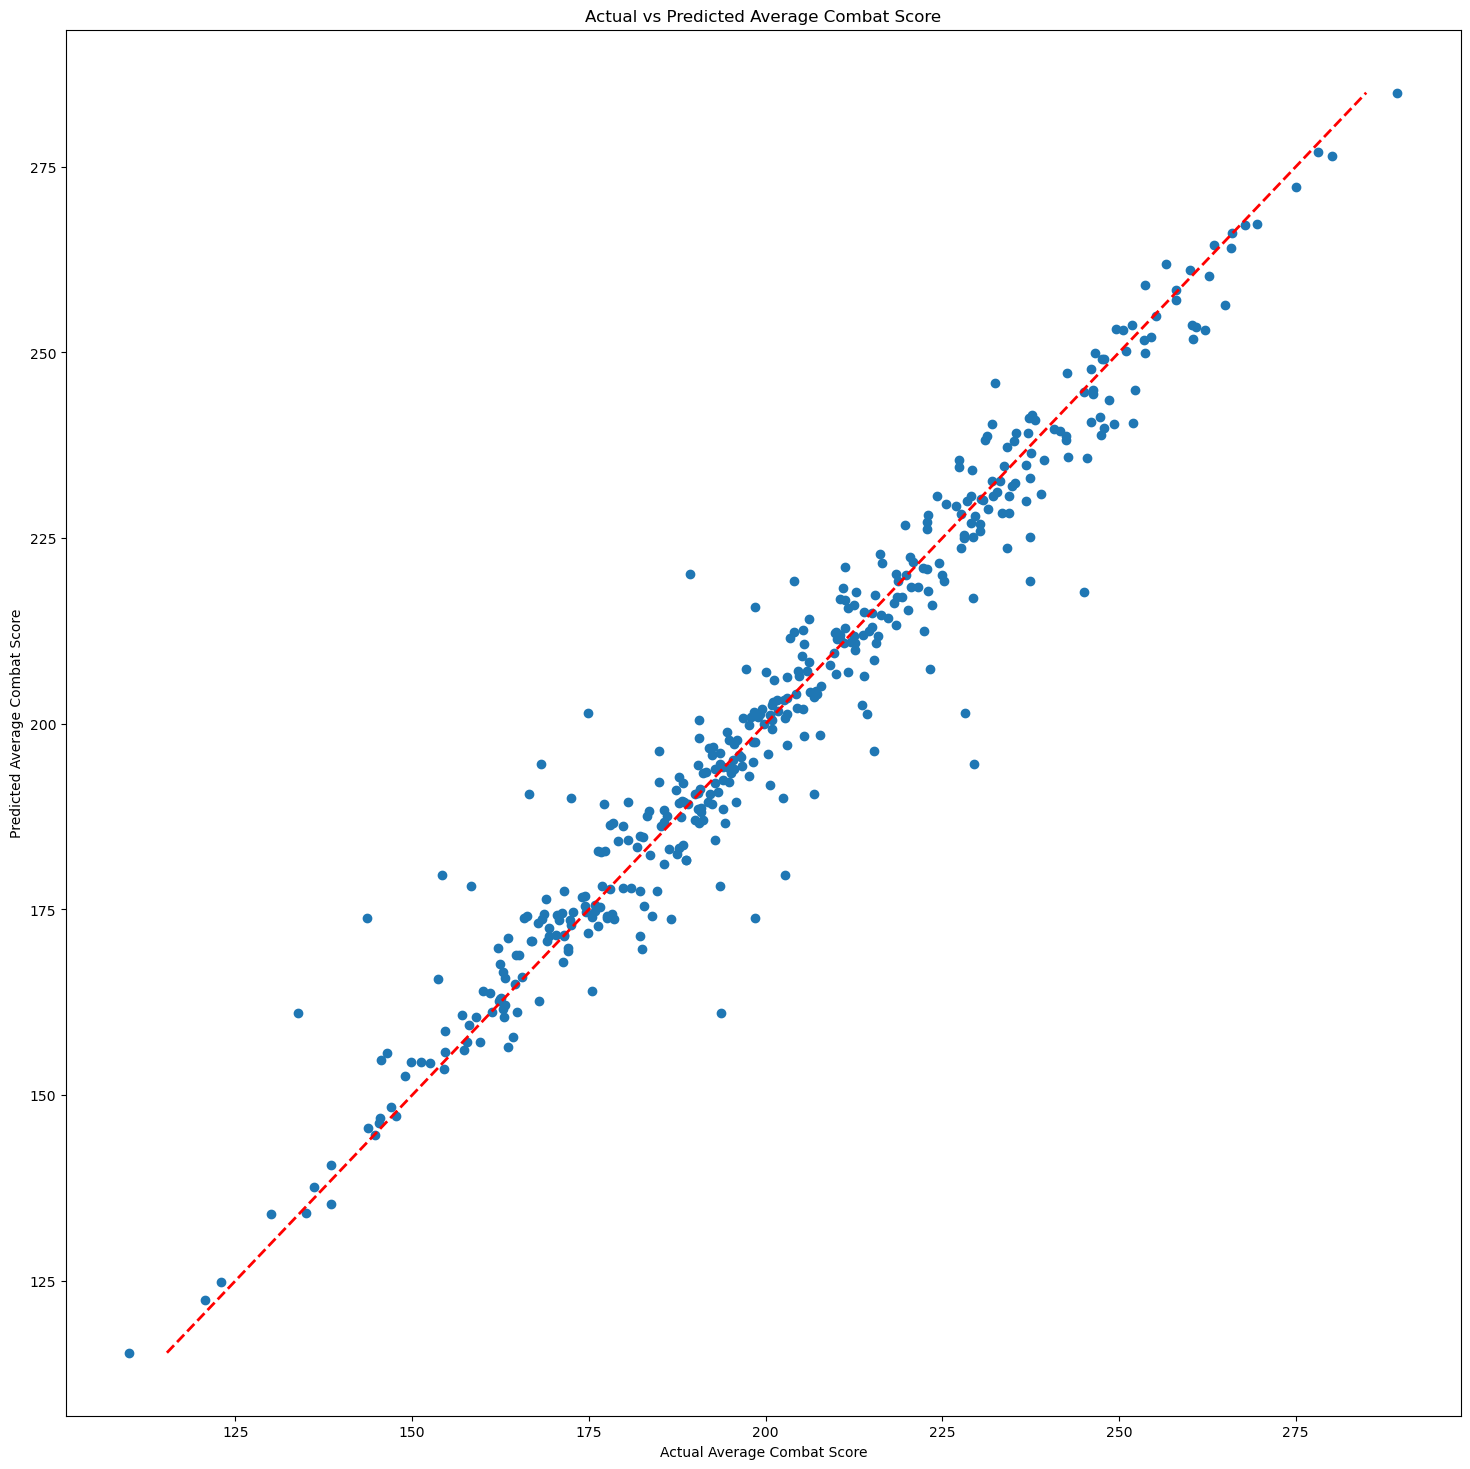

In [51]:
# Actual vs Predicted graph

# Create a larger figure
plt.figure(figsize=(18, 18))

# Plot actual vs predicted values with player names
plt.scatter(data['average_combat_score'], prediction_ACS)
plt.plot([min(prediction_ACS), max(prediction_ACS)], [min(prediction_ACS), max(prediction_ACS)], linestyle='--', color='red', linewidth=2)
plt.xlabel("Actual Average Combat Score")
plt.ylabel("Predicted Average Combat Score")
plt.title("Actual vs Predicted Average Combat Score")

plt.show()

In [54]:
#Predict Missing values
all_players_dates_pd = all_players_date(dates)
all_data = all_players_dates_pd.merge(data, on=['player', 'date'], how='left')
missing_data = all_data[pd.isna(all_data['average_combat_score'])].reset_index(drop=True)
missing_data_predict = playerStatPredictions(missing_data[['player', 'date']])
all_data = all_data.set_index(['player', 'date']).combine_first(missing_data_predict.set_index(['player', 'date'])).reset_index()

In [55]:
all_data

,player,date,assists_per_round,average_combat_score,average_damage_per_round,clutch_success_percentage,first_deaths_per_round,first_kills_per_round,headshot_percentage,kills_deaths,kills_per_round,rating,rounds,total_assists,total_deaths,total_first_deaths,total_first_kills,total_kills
0,ANGE1,2021-05-30,0.280504,157.109528,106.499619,0.100428,0.150643,0.081164,0.309156,NaN,0.530947,NaN,NaN,99.000572,276.000458,53.000515,27.000534,189.000504
1,ANGE1,2021-09-19,0.280504,157.109528,106.499619,0.100428,0.150643,0.081164,0.309156,NaN,0.530947,NaN,NaN,99.000572,276.000458,53.000515,27.000534,189.000504
2,ANGE1,2021-12-12,0.280504,157.109528,106.499619,0.100428,0.150643,0.081164,0.309156,NaN,0.530947,NaN,NaN,99.000572,276.000458,53.000515,27.000534,189.000504
3,ANGE1,2022-08-31,0.280000,159.600000,106.500000,0.100000,0.150000,0.080000,0.310000,0.68,0.530000,0.75,357.0,99.000000,276.000000,53.000000,27.000000,189.000000
4,ANGE1,2022-10-04,0.280504,173.618927,116.101387,0.108460,0.158327,0.100043,0.301052,NaN,0.590237,NaN,NaN,153.998245,412.998322,85.998245,57.998413,324.998291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,zekken,2022-10-04,0.219658,239.418854,157.998062,0.069801,0.139468,0.139895,0.231817,NaN,0.818548,NaN,NaN,26.000214,87.000099,17.000179,17.000107,97.000198
896,zekken,2022-10-07,0.220000,241.600000,158.000000,0.070000,0.140000,0.140000,0.230000,1.11,0.820000,1.09,119.0,26.000000,87.000000,17.000000,17.000000,97.000000
897,zekken,2023-02-13,0.280000,138.500000,77.300000,0.000000,0.130000,0.100000,0.240000,0.47,0.380000,0.60,39.0,10.000000,30.000000,4.000000,1.000000,16.000000
898,zekken,2023-06-08,0.279424,135.343216,77.300888,0.001087,0.131065,0.101014,0.239092,NaN,0.380965,NaN,NaN,10.000788,30.000875,4.000886,1.000824,16.000822


In [56]:
#Other graphs

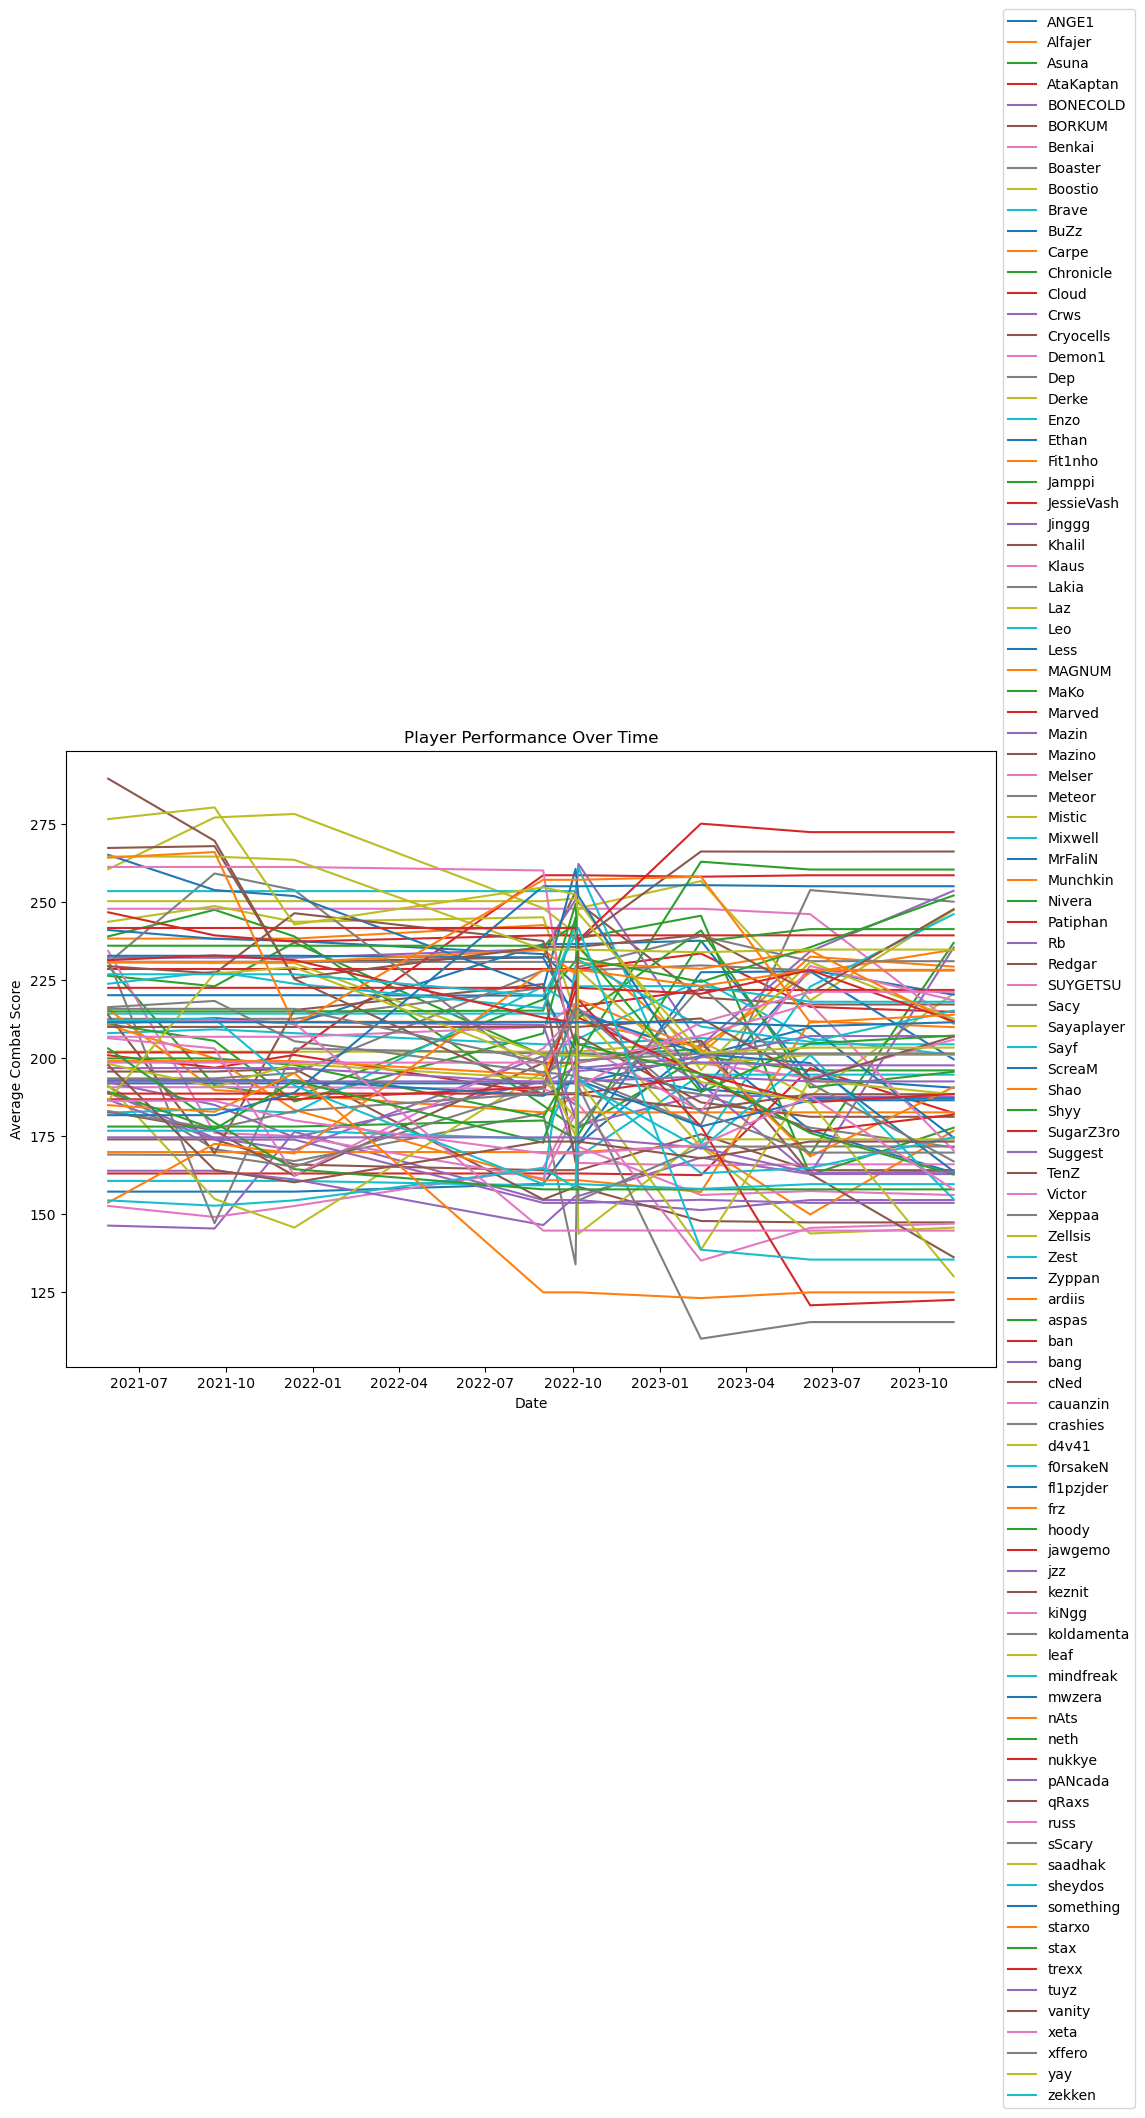

In [57]:
# Plot of all player performance over time

# Create a larger figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the performance of players from every tournament
for player_name, player_data in all_data.groupby('player'):
    ax.plot(player_data['date'], player_data['average_combat_score'], label=player_name)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Average Combat Score')
ax.set_title('Player Performance Over Time')

# Move the legend outside the plot box
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [58]:
# Plot of top 5 player performance over time

In [59]:
#Get top 5 players with ACS from this period
top_ACS_players = data.sort_values('average_combat_score', ascending=False).drop_duplicates(subset='player', keep='first')
top_5_ACS_players = top_ACS_players[['player', 'average_combat_score']].head(5)

In [60]:
top_5_ACS_players

,player,average_combat_score
118,TenZ,289.4
409,yay,280.2
152,Derke,278.1
207,trexx,275.0
176,cNed,267.8


In [61]:
top_5_ACS_players_data = all_data.loc[all_data['player'].isin(top_5_ACS_players['player'])]

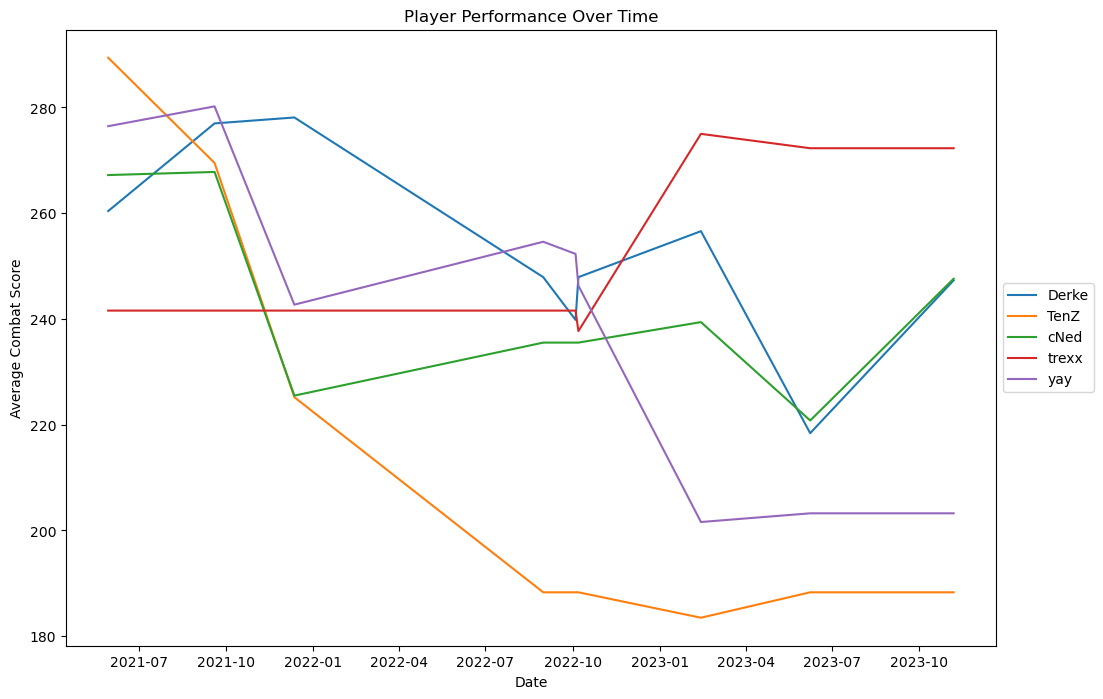

In [62]:
# Create a larger figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the performance of players from every tournament
for player_name, player_data in top_5_ACS_players_data.groupby('player'):
    ax.plot(player_data['date'], player_data['average_combat_score'], label=player_name)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Average Combat Score')
ax.set_title('Player Performance Over Time')

# Move the legend outside the plot box
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [63]:
#Get ACS and stats of players at next tournament date
next_tourney_date = '2024/1/23'
players_tournament = pd.DataFrame({'player':players, 'date':next_tourney_date})
players_tournament['date'] = pd.to_datetime(players_tournament['date'])

In [64]:
players_tournament = playerStatPredictions(players_tournament)

In [65]:
#Top 10 players next tournament
players_tournament.sort_values('average_combat_score', ascending=False).head(10)

,player,date,kills_per_round,assists_per_round,average_damage_per_round,first_kills_per_round,first_deaths_per_round,headshot_percentage,clutch_success_percentage,total_kills,total_deaths,total_assists,total_first_kills,total_first_deaths,average_combat_score
51,trexx,2024-01-23,0.999057,0.200870,181.199005,0.070969,0.090874,0.319050,0.000987,46.000931,27.000933,9.000902,3.000859,4.000889,272.286285
11,keznit,2024-01-23,0.878904,0.229039,175.798798,0.209189,0.091205,0.201045,0.179083,79.000862,70.001015,20.999426,19.000978,8.000966,266.073761
48,Nivera,2024-01-23,0.898885,0.359349,158.698868,0.898865,0.089124,0.329429,0.061128,93.000656,70.000916,36.999680,19.000547,9.000886,260.296021
93,JessieVash,2024-01-23,0.899092,0.320980,170.099121,0.109016,0.129126,0.309012,0.100870,71.000862,67.000931,25.000969,9.000877,10.000854,258.464569
8,mwzera,2024-01-23,0.929145,0.319054,165.999008,0.089088,0.070000,0.199031,0.219123,70.999077,54.000854,23.998997,6.999077,5.000921,254.948135
83,Jinggg,2024-01-23,0.858816,0.230535,166.498810,0.140623,0.140657,0.181147,0.050592,284.999451,262.000336,78.000443,47.000492,48.000465,251.623764
94,Dep,2024-01-23,0.888979,0.081019,156.298859,0.119305,0.080955,0.280530,0.000609,69.999649,64.999672,5.999677,5.999609,4.000884,249.996002
43,cNed,2024-01-23,0.849179,0.219374,157.299255,0.219455,0.140664,0.230683,0.001017,106.000992,103.000969,26.999535,26.999481,17.000937,249.081543
37,Derke,2024-01-23,0.819257,0.199106,157.699524,0.239008,0.219042,0.221077,0.379010,172.999573,147.000839,42.000546,51.000847,47.000973,241.293396
12,Shyy,2024-01-23,0.868922,0.200995,154.798965,0.159167,0.021016,0.210946,0.150955,109.001022,79.000885,25.000813,19.998974,3.000835,241.216003


In [66]:
#Get ACS and stats of players at next tournaments
future_dates = ['2024-01-23', '2024-03-15', '2024-04-01']

In [67]:
multiple_player_tournament = playerStatPredictions(all_players_date(future_dates))

In [68]:
multiple_player_tournament

,player,date,kills_per_round,assists_per_round,average_damage_per_round,first_kills_per_round,first_deaths_per_round,headshot_percentage,clutch_success_percentage,total_kills,total_deaths,total_assists,total_first_kills,total_first_deaths,average_combat_score
0,Cryocells,2024-01-23,0.751031,0.248989,137.500961,0.131064,0.179191,0.180958,0.001072,130.999496,129.999496,53.999027,22.999676,31.999338,217.063354
1,Cryocells,2024-03-15,0.751031,0.248989,137.500961,0.131064,0.179191,0.180958,0.001072,130.999496,129.999496,53.999027,22.999676,31.999338,217.063354
2,Cryocells,2024-04-01,0.751031,0.248989,137.500961,0.131064,0.179191,0.180958,0.001072,130.999496,129.999496,53.999027,22.999676,31.999338,217.063354
3,bang,2024-01-23,0.739053,0.340874,134.499023,0.129012,0.119053,0.390984,0.050916,128.999023,130.999039,58.998993,21.998999,20.999117,206.947983
4,bang,2024-03-15,0.739053,0.340874,134.499023,0.129012,0.119053,0.390984,0.050916,128.999023,130.999039,58.998993,21.998999,20.999117,206.947983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,yay,2024-03-15,0.751013,0.149250,127.400864,0.151045,0.120566,0.289056,0.081024,67.000954,54.000904,13.000848,13.000909,11.000880,203.243805
296,yay,2024-04-01,0.751013,0.149250,127.400864,0.151045,0.120566,0.289056,0.081024,67.000954,54.000904,13.000848,13.000909,11.000880,203.243805
297,hoody,2024-01-23,0.699509,0.459046,138.999573,0.098986,0.119128,0.230462,0.121035,112.998993,112.998940,73.998993,15.998913,18.998989,207.090927
298,hoody,2024-03-15,0.699509,0.459046,138.999573,0.098986,0.119128,0.230462,0.121035,112.998993,112.998940,73.998993,15.998913,18.998989,207.090927


In [69]:
#Top 10 players at the next 3 tournaments
multiple_player_tournament[['player', 'date', 'average_combat_score']].sort_values('average_combat_score', ascending=False).head(10)

,player,date,average_combat_score
154,trexx,2024-03-15,272.286285
155,trexx,2024-04-01,272.286285
153,trexx,2024-01-23,272.286285
35,keznit,2024-04-01,266.073761
34,keznit,2024-03-15,266.073761
33,keznit,2024-01-23,266.073761
144,Nivera,2024-01-23,260.296021
146,Nivera,2024-04-01,260.296021
145,Nivera,2024-03-15,260.296021
281,JessieVash,2024-04-01,258.464569


In [70]:
#Get top 5 players with ACS from this period
top_ACS_players_next = multiple_player_tournament.sort_values('average_combat_score', ascending=False).drop_duplicates(subset='player', keep='first')
top_5_ACS_players_next = top_ACS_players_next[['player', 'average_combat_score']].head(5)

In [71]:
top_5_ACS_players_next

,player,average_combat_score
154,trexx,272.286285
35,keznit,266.073761
144,Nivera,260.296021
281,JessieVash,258.464569
26,mwzera,254.948135


In [72]:
top_5_ACS_players_next_data = multiple_player_tournament.loc[multiple_player_tournament['player'].isin(top_5_ACS_players['player'])]

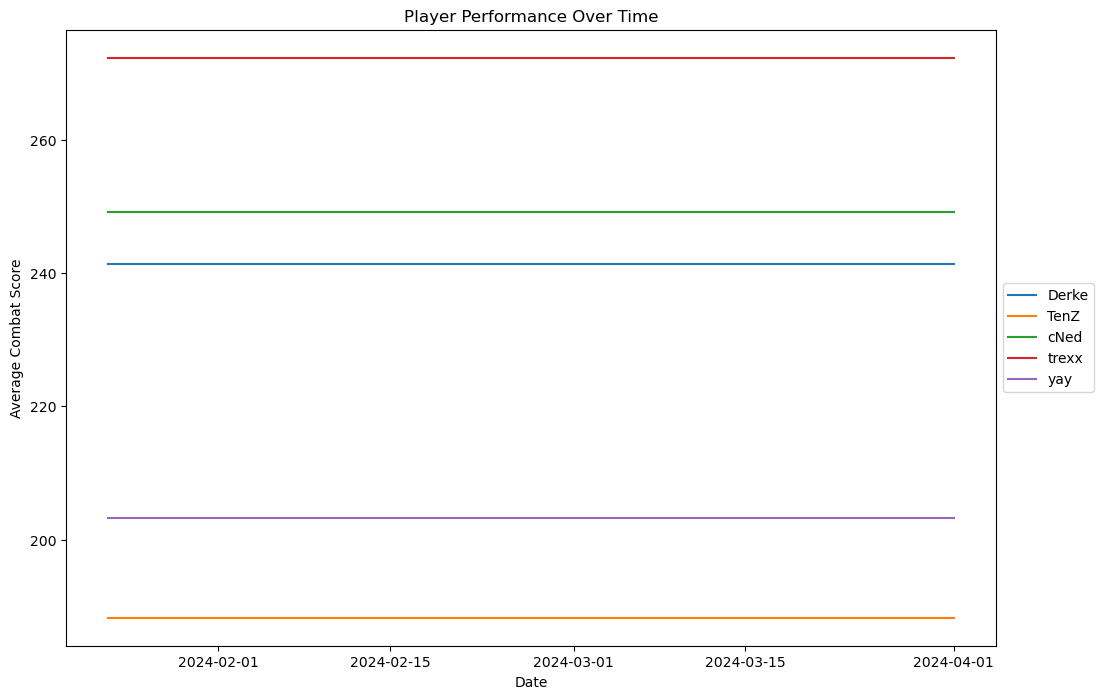

In [73]:
#Plot performance
# Create a larger figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the performance of players from every tournament
for player_name, player_data in top_5_ACS_players_next_data.groupby('player'):
    ax.plot(player_data['date'], player_data['average_combat_score'], label=player_name)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Average Combat Score')
ax.set_title('Player Performance Over Time')

# Move the legend outside the plot box
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [74]:
#Join two models
all_data_extend = pd.concat([all_data, multiple_player_tournament])

In [75]:
all_data_extend

,player,date,assists_per_round,average_combat_score,average_damage_per_round,clutch_success_percentage,first_deaths_per_round,first_kills_per_round,headshot_percentage,kills_deaths,kills_per_round,rating,rounds,total_assists,total_deaths,total_first_deaths,total_first_kills,total_kills
0,ANGE1,2021-05-30,0.280504,157.109528,106.499619,0.100428,0.150643,0.081164,0.309156,NaN,0.530947,NaN,NaN,99.000572,276.000458,53.000515,27.000534,189.000504
1,ANGE1,2021-09-19,0.280504,157.109528,106.499619,0.100428,0.150643,0.081164,0.309156,NaN,0.530947,NaN,NaN,99.000572,276.000458,53.000515,27.000534,189.000504
2,ANGE1,2021-12-12,0.280504,157.109528,106.499619,0.100428,0.150643,0.081164,0.309156,NaN,0.530947,NaN,NaN,99.000572,276.000458,53.000515,27.000534,189.000504
3,ANGE1,2022-08-31,0.280000,159.600000,106.500000,0.100000,0.150000,0.080000,0.310000,0.68,0.530000,0.75,357.0,99.000000,276.000000,53.000000,27.000000,189.000000
4,ANGE1,2022-10-04,0.280504,173.618927,116.101387,0.108460,0.158327,0.100043,0.301052,NaN,0.590237,NaN,NaN,153.998245,412.998322,85.998245,57.998413,324.998291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,yay,2024-03-15,0.149250,203.243805,127.400864,0.081024,0.120566,0.151045,0.289056,NaN,0.751013,NaN,NaN,13.000848,54.000904,11.000880,13.000909,67.000954
296,yay,2024-04-01,0.149250,203.243805,127.400864,0.081024,0.120566,0.151045,0.289056,NaN,0.751013,NaN,NaN,13.000848,54.000904,11.000880,13.000909,67.000954
297,hoody,2024-01-23,0.459046,207.090927,138.999573,0.121035,0.119128,0.098986,0.230462,NaN,0.699509,NaN,NaN,73.998993,112.998940,18.998989,15.998913,112.998993
298,hoody,2024-03-15,0.459046,207.090927,138.999573,0.121035,0.119128,0.098986,0.230462,NaN,0.699509,NaN,NaN,73.998993,112.998940,18.998989,15.998913,112.998993


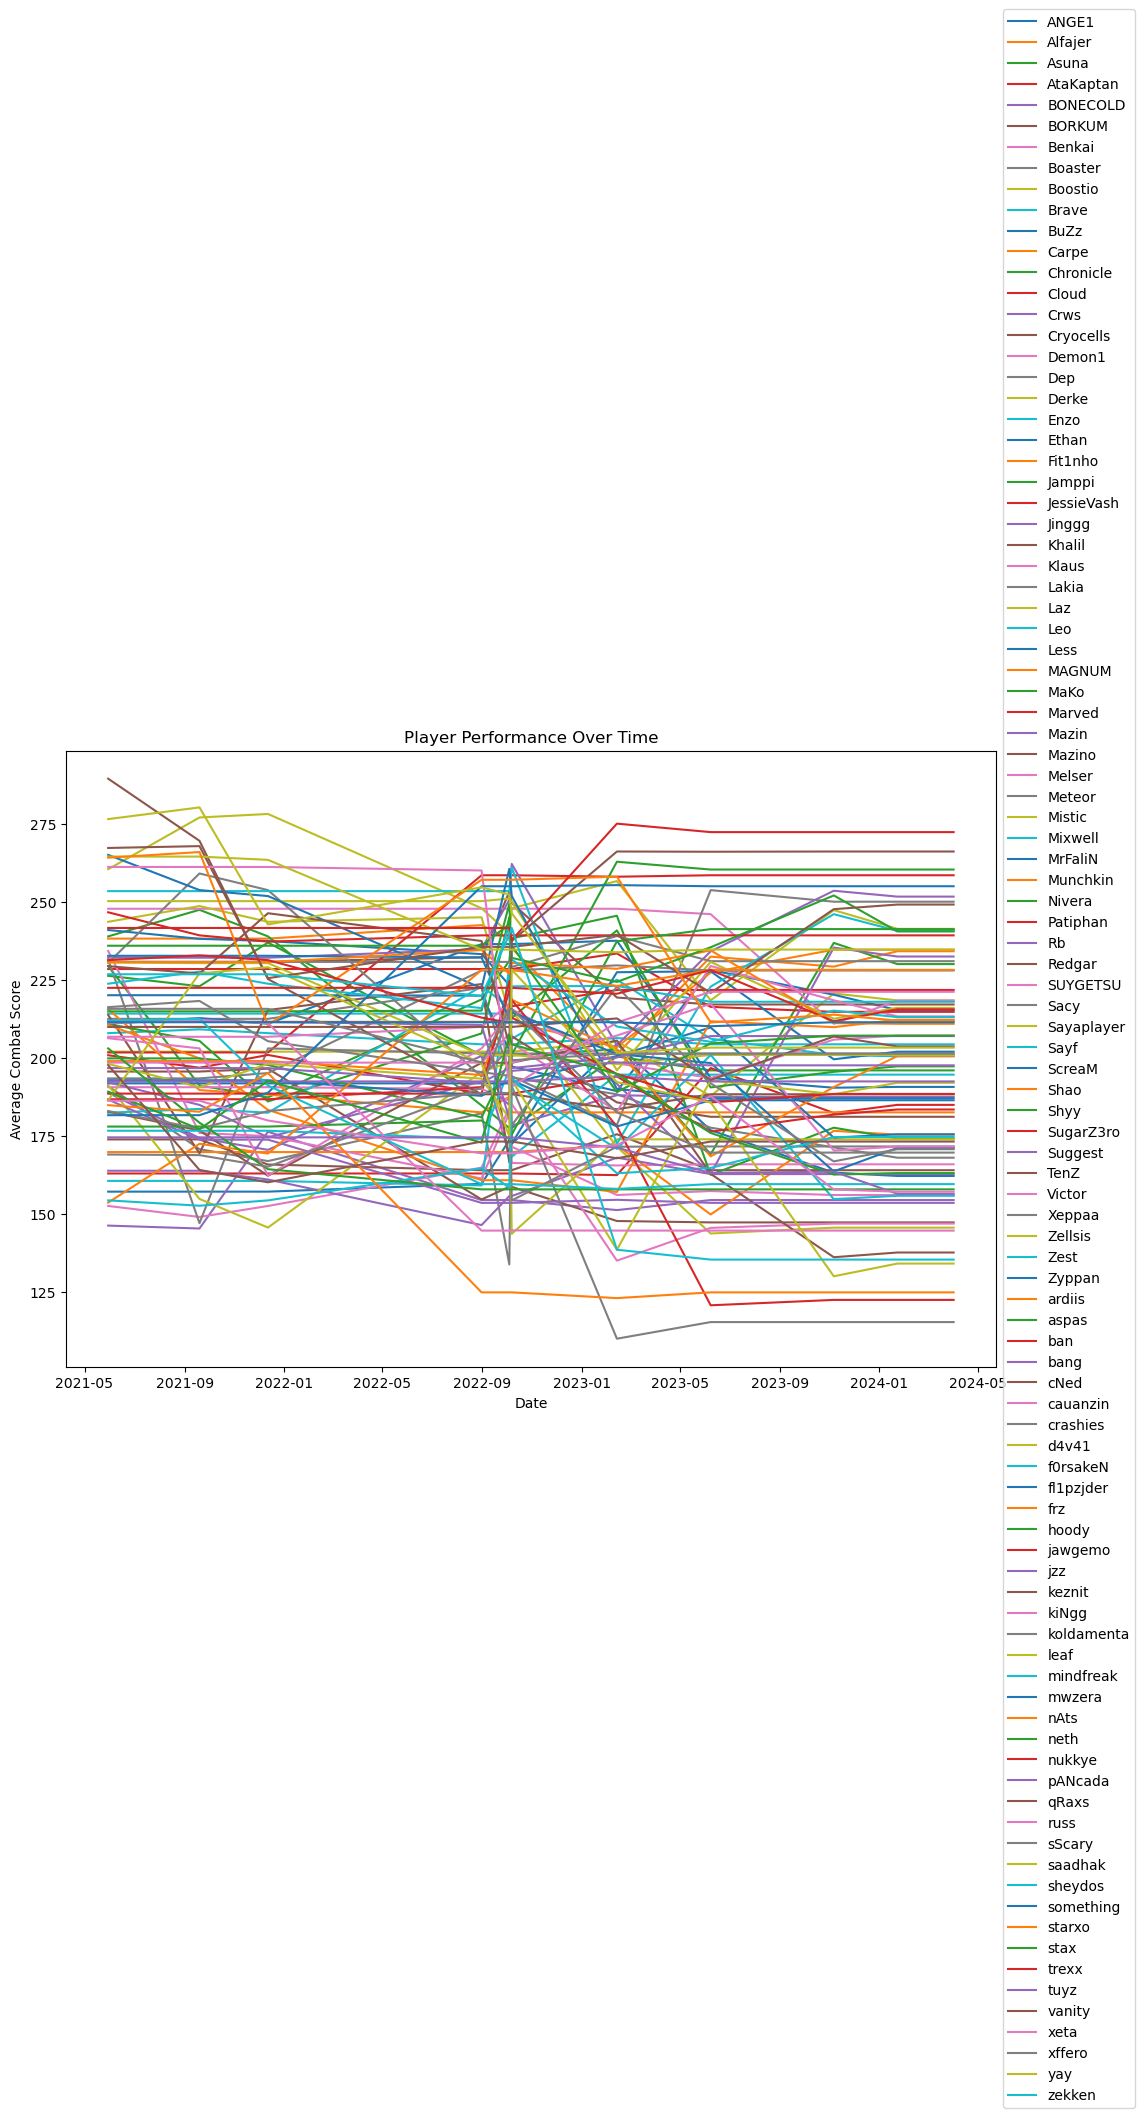

In [89]:
# Plot of all player performance over time

# Create a larger figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the performance of players from every tournament
for player_name, player_data in all_data_extend.groupby('player'):
    ax.plot(player_data['date'], player_data['average_combat_score'], label=player_name)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Average Combat Score')
ax.set_title('Player Performance Over Time')

# Move the legend outside the plot box
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [85]:
#Get top 10 players with ACS from this period
top_ACS_players_all = all_data_extend.sort_values('average_combat_score', ascending=False).drop_duplicates(subset='player', keep='first')
top_10_ACS_players_all = top_ACS_players[['player', 'average_combat_score']].head(10)

In [86]:
top_10_ACS_players_all

,player,average_combat_score
118,TenZ,289.4
409,yay,280.2
152,Derke,278.1
207,trexx,275.0
176,cNed,267.8
40,keznit,266.0
252,nAts,265.9
198,ScreaM,265.0
134,leaf,263.4
197,Nivera,262.8


In [87]:
top_10_ACS_players_data_all = all_data_extend.loc[all_data_extend['player'].isin(top_10_ACS_players_all['player'])]

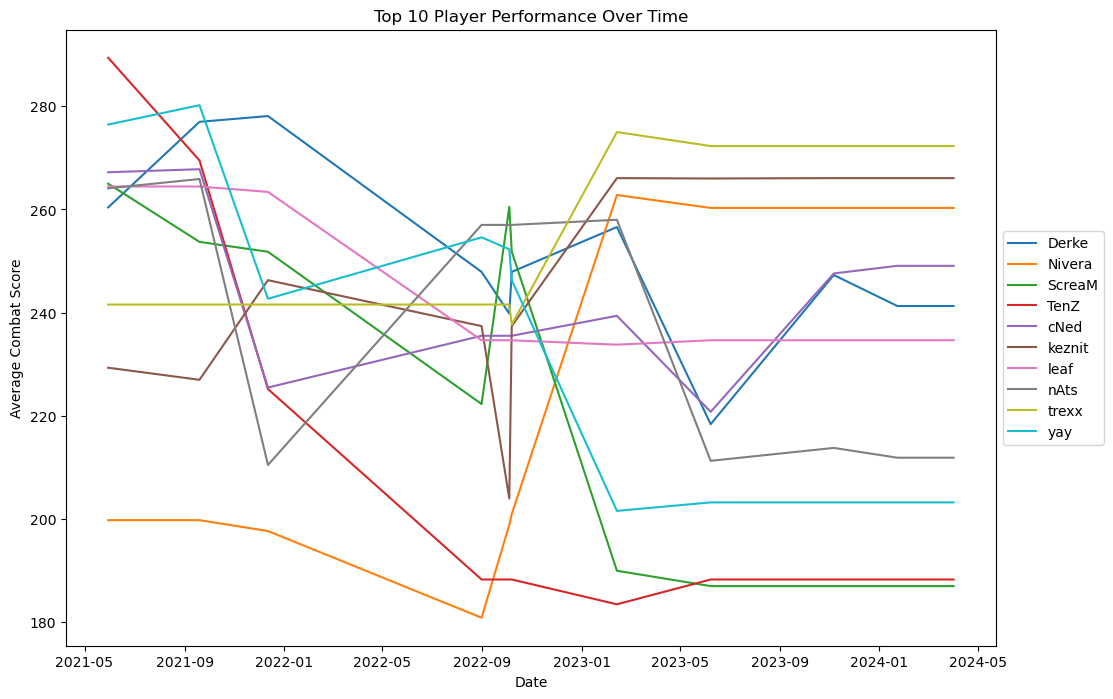

In [90]:
#Plot performance
# Create a larger figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the performance of players from every tournament
for player_name, player_data in top_10_ACS_players_data_all.groupby('player'):
    ax.plot(player_data['date'], player_data['average_combat_score'], label=player_name)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Average Combat Score')
ax.set_title('Top 10 Player Performance Over Time')

# Move the legend outside the plot box
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()